# Degradation and soiling example with clearsky workflow


This jupyter notebook is intended to the RdTools analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow. For a consistent experience, we recommend installing the specific versions of packages used to develop this notebook. This can be achieved in your environment by running `pip install -r requirements.txt` followed by `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.) These environments and examples are tested with Python 3.7.

The calculations consist of several steps illustrated here:
<ol start="0">
  <li><b>Import and preliminary calculations</b></li>
  <li><b>Normalize</b> data using a performance metric</li>
  <li><b>Filter</b> data that creates bias</li>
  <li><b>Aggregate data</b></li>
  <li> <b>Analyze</b> aggregated data to estimate the degradation rate</li>
  <li> <b>Analyze</b> aggregated data to estimate the soiling loss</li>
</ol>

After demonstrating these steps using sensor data, a modified version of the workflow is illustrated using modeled clear sky irradiance and temperature. The results from the two methods are compared at the end.

This notebook works with data from the NREL PVDAQ `[4] NREL x-Si #1` system.  Note that because this system does not experience significant soiling, the dataset contains a synthesized soiling signal for use in the soiling section of the example.  This notebook automatically downloads and locally caches the dataset used in this example. The data can also be found on the DuraMAT Datahub (https://datahub.duramat.org/dataset/pvdaq-time-series-with-soiling-signal).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })
# Register time series plotting in pandas > 1.0
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Set the random seed for numpy to ensure consistent results
np.random.seed(0)

## 0: Import and preliminary calculations


This section prepares the data necessary for an `rdtools` calculation. The first step of the `rdtools` workflow is normalization, which requires a time series of energy yield, a time series of cell temperature, and a time series of irradiance, along with some metadata (see Step 1: Normalize)

The following section loads the data, adjusts units where needed, and renames the critical columns. The ambient temperature sensor data source is converted into estimated cell temperature.  This dataset already has plane-of-array irradiance data, so no transposition is necessary.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

<b>The steps of this section may change depending on your data source or the system being considered.</b>  Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are available in [pvlib](https://github.com/pvlib/pvlib-python).

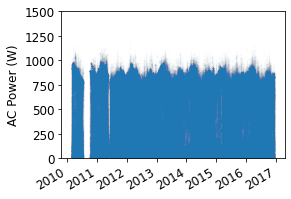

In [4]:
# Import the example data
file_url = ('https://datahub.duramat.org/dataset/a49bb656-7b36-'
            '437a-8089-1870a40c2a7d/resource/5059bc22-640d-4dd4'
            '-b7b1-1e71da15be24/download/pvdaq_system_4_2010-2016'
            '_subset_soilsignal.csv')
cache_file = 'PVDAQ_system_4_2010-2016_subset_soilsignal.pickle'

try:
    df = pd.read_pickle(cache_file)
except FileNotFoundError:
    df = pd.read_csv(file_url, index_col=0, parse_dates=True)
    df.to_pickle(cache_file)

df = df.rename(columns = {
    'ambient_temp': 'Tamb',
    'poa_irradiance': 'poa',
})

# Specify the Metadata
meta = {"latitude": 39.7406,
        "longitude": -105.1774,
        "timezone": 'Etc/GMT+7',
        "gamma_pdc": -0.005,
        "azimuth": 180,
        "tilt": 40,
        "power_dc_rated": 1000.0,
        "temp_model_params":
        pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']}

df.index = df.index.tz_localize(meta['timezone'])

# There is some missing data, but we can infer the frequency from
# the first several data points
freq = pd.infer_freq(df.index[:10])

# Then set the frequency of the dataframe.
# It is recommended not to up- or downsample at this step
# but rather to use interpolate to regularize the time series
# to its dominant or underlying frequency. Interpolate is not
# generally recommended for downsampling in this application.
df = rdtools.interpolate(df, freq)

# Calculate cell temperature
df['Tcell'] = pvlib.temperature.sapm_cell(df.poa, df.Tamb,
                                          df.wind_speed, **meta['temp_model_params'])

# plot the AC power time series
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.ac_power, 'o', alpha=0.01)
ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

This example dataset includes a synthetic soiling signal that can be applied onto the PV power data to illustrate the soiling loss and detection capabilities of RdTools.  AC Power is multiplied by soiling to create the synthetic 'power' channel

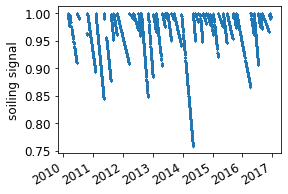

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.soiling, 'o', alpha=0.01)
#ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('soiling signal');

df['power'] = df['ac_power'] * df['soiling']

## 1: Normalize

Data normalization is achieved with `rdtools.normalize_with_expected_power()`. This function can be used to normalize to any modeled or expected power. Note that realized PV output can be given as energy, rather than power, by using an optional key word argument. 

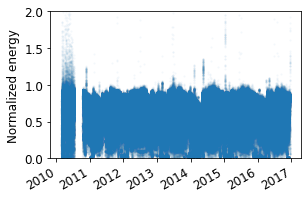

In [6]:
# Calculate the expected power with a simple PVWatts DC model
modeled_power = pvlib.pvsystem.pvwatts_dc(df['poa'], df['Tcell'], meta['power_dc_rated'],
                                          meta['gamma_pdc'], 25.0 )

# Calculate the normalization, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
normalized, insolation = rdtools.normalize_with_expected_power(df['power'],
                                                               modeled_power,
                                                               df['poa'])

df['normalized'] = normalized
df['insolation'] = insolation

# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

## 2: Filter

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.

It can also be useful to remove outages and outliers. Sometimes outages appear as low but non-zero yield. Automatic functions for outage detection are not yet included in `rdtools`.  However, this example does filter out data points where the normalized energy is less than 1%.  System-specific filters should be implemented by the analyst if needed.

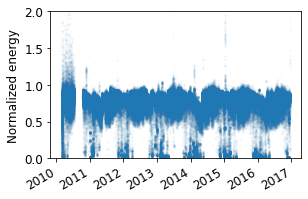

In [7]:
# Calculate a collection of boolean masks that can be used
# to filter the time series
normalized_mask = rdtools.normalized_filter(df['normalized'])
poa_mask = rdtools.poa_filter(df['poa'])
tcell_mask = rdtools.tcell_filter(df['Tcell'])
# Note: This clipping mask may be disabled when you are sure the system is not 
# experiencing clipping due to high DC/AC ratio
clip_mask = rdtools.clip_filter(df['power'])

# filter the time series and keep only the columns needed for the
# remaining steps
filtered = df[normalized_mask & poa_mask & tcell_mask & clip_mask]
filtered = filtered[['insolation', 'normalized']]

fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

## 3: Aggregate

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

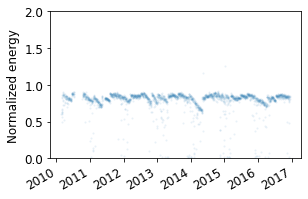

In [8]:
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation,
                                  frequency = 'D')

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

## 4: Degradation calculation

Data is then analyzed to estimate the degradation rate representing the PV system behavior. The results are visualized and statistics are reported, including the 68.2% confidence interval, and the P95 exceedance value.

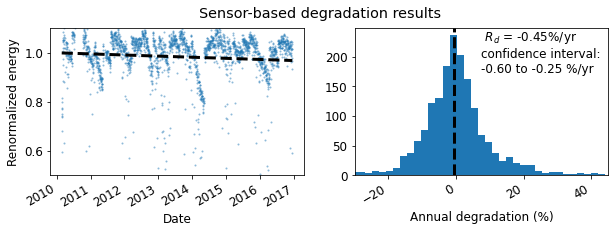

In [9]:
# Calculate the degradation rate using the YoY method
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily, confidence_level=68.2)
# Note the default confidence_level of 68.2 is appropriate if you would like to 
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results

degradation_fig = rdtools.degradation_summary_plots(
    yoy_rd, yoy_ci, yoy_info, daily,
    summary_title='Sensor-based degradation results',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, bins=100
)

In addition to the confidence interval, the year-on-year method yields an exceedance value (e.g. P95), the degradation rate that was exceeded (slower degradation) with a given probability level. The probability level is set via the `exceedance_prob` keyword in `degradation_year_on_year`.

In [10]:
print('The P95 exceedance level is %.2f%%/yr' % yoy_info['exceedance_level'])

The P95 exceedance level is -0.72%/yr


In [11]:
print(yoy_rd)
print(yoy_ci)

-0.4540480935921178
[-0.60485954 -0.25286447]


## 5: Soiling calculations  

This section illustrates how the aggregated data can be used to estimate soiling losses using the stochastic rate and recovery (SRR) method.¹ Since our example system doesn't experience much soiling, we apply an artificially generated soiling signal, just for the sake of example.

¹ M. G. Deceglie, L. Micheli and M. Muller, "Quantifying Soiling Loss Directly From PV Yield," IEEE Journal of Photovoltaics, vol. 8, no. 2, pp. 547-551, March 2018. doi: 10.1109/JPHOTOV.2017.2784682

In [12]:
# Calculate the daily insolation, required for the SRR calculation
daily_insolation = filtered['insolation'].resample('D').sum()

# Perform the SRR calculation
from rdtools.soiling import soiling_srr
cl = 68.2
sr, sr_ci, soiling_info = soiling_srr(daily, daily_insolation,
                                      confidence_level=cl)

/Users/mdecegli/Documents/GitHub/rdtools/rdtools/soiling.py:15: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  'The soiling module is currently experimental. The API, results, '
/Users/mdecegli/Documents/GitHub/rdtools/rdtools/soiling.py:358: UserWarning: 20% or more of the daily data is assigned to invalid soiling intervals. This can be problematic with the "half_norm_clean" and "random_clean" cleaning assumptions. Consider more permissive validity criteria such as increasing "max_relative_slope_error" and/or "max_negative_step" and/or decreasing "min_interval_length". Alternatively, consider using method="perfect_clean". For more info see https://github.com/NREL/rdtools/issues/272
  warnings.warn('20% or more of the daily data is assigned to invalid soiling '


In [13]:
print('The P50 insolation-weighted soiling ratio is %0.3f'%sr)

The P50 insolation-weighted soiling ratio is 0.952


In [14]:
print('The %0.1f confidence interval for the insolation-weighted'
      ' soiling ratio is %0.3f–%0.3f'%(cl, sr_ci[0], sr_ci[1]))

The 68.2 confidence interval for the insolation-weighted soiling ratio is 0.947–0.957


/Users/mdecegli/Documents/GitHub/rdtools/rdtools/plotting.py:152: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  'The soiling module is currently experimental. The API, results, '


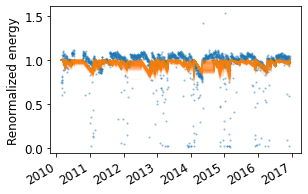

In [15]:
# Plot Monte Carlo realizations of soiling profiles
fig = rdtools.plotting.soiling_monte_carlo_plot(soiling_info, daily, profiles=200);

/Users/mdecegli/Documents/GitHub/rdtools/rdtools/plotting.py:212: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  'The soiling module is currently experimental. The API, results, '


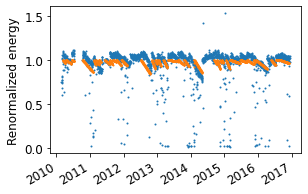

In [16]:
# Plot the slopes for "valid" soiling intervals identified,
# assuming perfect cleaning events
fig = rdtools.plotting.soiling_interval_plot(soiling_info, daily);

In [17]:
# View the first several rows of the soiling interval summary table
soiling_summary = soiling_info['soiling_interval_summary']
soiling_summary.head()

,start,end,soiling_rate,soiling_rate_low,soiling_rate_high,inferred_start_loss,inferred_end_loss,length,valid
0,2010-02-25 00:00:00-07:00,2010-03-03 00:00:00-07:00,0.0,0.0,0.0,0.729104,0.757749,6,False
1,2010-03-04 00:00:00-07:00,2010-03-04 00:00:00-07:00,0.0,0.0,0.0,0.800385,0.800385,0,False
2,2010-03-05 00:00:00-07:00,2010-03-05 00:00:00-07:00,0.0,0.0,0.0,0.814419,0.814419,0,False
3,2010-03-06 00:00:00-07:00,2010-03-06 00:00:00-07:00,0.0,0.0,0.0,1.060073,1.060073,0,False
4,2010-03-07 00:00:00-07:00,2010-03-09 00:00:00-07:00,0.0,0.0,0.0,1.004625,1.036331,2,False


/Users/mdecegli/Documents/GitHub/rdtools/rdtools/plotting.py:252: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  'The soiling module is currently experimental. The API, results, '


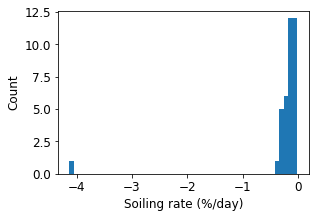

In [18]:
# View a histogram of the valid soiling rates found for the data set
fig = rdtools.plotting.soiling_rate_histogram(soiling_info, bins=50)

These plots show generally good results from the SRR method. In this example, we have slightly overestimated the soiling loss because we used the default behavior of the `method` key word argument in `rdtools.soiling_srr()`, which does not assume that every cleaning is perfect but the example artificial soiling signal did include perfect cleaning. We encourage you to adjust the options of `rdtools.soiling_srr()` for your application.

In [19]:
# Calculate and view a monthly soiling rate summary
from rdtools.soiling import monthly_soiling_rates
monthly_soiling_rates(soiling_info['soiling_interval_summary'],
                      confidence_level=cl)

,month,soiling_rate_median,soiling_rate_low,soiling_rate_high,interval_count
0,1,-0.001135,-0.002064,-0.000788,5
1,2,-0.001621,-0.003785,-0.000830,7
2,3,-0.001480,-0.002202,-0.000518,7
3,4,-0.001169,-0.001964,-0.000379,9
4,5,-0.000401,-0.000937,-0.000199,5
5,6,-0.000632,-0.001209,-0.000233,7
6,7,-0.000541,-0.001424,-0.000204,7
7,8,-0.000650,-0.001668,-0.000273,8
8,9,-0.000799,-0.001583,-0.000394,8
9,10,-0.000969,-0.001777,-0.000467,10


In [20]:
# Calculate and view annual insolation-weighted soiling ratios and their confidence
# intervals based on the Monte Carlo simulation. Note that these losses include the
# assumptions of the cleaning assumptions associated with the method parameter
# of rdtools.soiling_srr(). For anything but 'perfect_clean', each year's soiling
# ratio may be impacted by prior years' soiling profiles. The default behavior of
# rdtools.soiling_srr uses method='half_norm_clean'

from rdtools.soiling import annual_soiling_ratios
annual_soiling_ratios(soiling_info['stochastic_soiling_profiles'],
                      daily_insolation,
                      confidence_level=cl)

,year,soiling_ratio_median,soiling_ratio_low,soiling_ratio_high
0,2010,0.964229,0.954696,0.971185
1,2011,0.958098,0.952081,0.962811
2,2012,0.932075,0.912315,0.947379
3,2013,0.963429,0.954436,0.971176
4,2014,0.933805,0.915348,0.952533
5,2015,0.968523,0.961731,0.973910
6,2016,0.958139,0.948590,0.964991


## Clear sky workflow
The clear sky workflow is useful in that it avoids problems due to drift or recalibration of ground-based sensors. We use `pvlib` to model the clear sky irradiance. This is renormalized to align it with ground-based measurements. Finally we use `rdtools.get_clearsky_tamb()` to model the ambient temperature on clear sky days. This modeled ambient temperature is used to model cell temperature with `pvlib`. If high quality ambient temperature data is available, that can be used instead of the modeled ambient; we proceed with the modeled ambient temperature here for illustrative purposes.

In this example, note that we have omitted wind data in the cell temperature calculations for illustrative purposes. Wind data can also be included when the data source is trusted for improved results

We generally recommend that the clear sky workflow be used as a check on the sensor workflow. It tends to be more sensitive than the sensor workflow, and thus we don't recommend it as a stand-alone analysis.

**Note that the calculations below rely on some objects from the steps above**

## Clear Sky 0: Preliminary Calculations

In [21]:
# Calculate the clear sky POA irradiance

loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)
clearsky = loc.get_clearsky(df.index, solar_position=sun)

cs_irradiance = pvlib.irradiance.get_total_irradiance(meta['tilt'], meta['azimuth'], sun['apparent_zenith'],
                                                     sun['azimuth'], clearsky['dni'], clearsky['ghi'],
                                                     clearsky['dhi'])
df['clearsky_poa'] = cs_irradiance.poa_global
# Renormalize the clear sky POA irradiance
df['clearsky_poa'] = rdtools.irradiance_rescale(df.poa, df.clearsky_poa,
                                                method='iterative')

# Calculate the clearsky temperature
df['clearsky_Tamb'] = rdtools.get_clearsky_tamb(df.index, meta['latitude'],
                                                meta['longitude'])
df['clearsky_Tcell'] = pvlib.temperature.sapm_cell(df.clearsky_poa, df.clearsky_Tamb,
                                                   0, **meta['temp_model_params'])

## Clear Sky 1: Normalize
Normalize as in step 1 above, but this time using clearsky modeled irradiance and cell temperature

In [22]:
# Calculate the expected power with a simple PVWatts DC model
clearsky_modeled_power = pvlib.pvsystem.pvwatts_dc(df['clearsky_poa'],
                                                   df['clearsky_Tcell'],
                                                   meta['power_dc_rated'], meta['gamma_pdc'], 25.0 )

# Calculate the normalization, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
clearsky_normalized, clearsky_insolation = rdtools.normalize_with_expected_power(
    df['power'],
    clearsky_modeled_power,
    df['clearsky_poa']
)

df['clearsky_normalized'] = clearsky_normalized
df['clearsky_insolation'] = clearsky_insolation

## Clear Sky 2: Filter
Filter as in step 2 above, but with the addition of a clear sky index (csi) filter so we consider only points well modeled by the clear sky irradiance model.

In [23]:
# Perform clearsky filter
cs_normalized_mask = rdtools.normalized_filter(df['clearsky_normalized'])
cs_poa_mask = rdtools.poa_filter(df['clearsky_poa'])
cs_tcell_mask = rdtools.tcell_filter(df['clearsky_Tcell'])

csi_mask = rdtools.csi_filter(df.insolation, df.clearsky_insolation)

clearsky_filtered = df[cs_normalized_mask & cs_poa_mask & cs_tcell_mask &
                       clip_mask & csi_mask]
clearsky_filtered = clearsky_filtered[['clearsky_insolation', 'clearsky_normalized']]

## Clear Sky 3: Aggregate
Aggregate the clear sky version of of the filtered data 

In [24]:
clearsky_daily = rdtools.aggregation_insol(clearsky_filtered.clearsky_normalized,
                                           clearsky_filtered.clearsky_insolation)

## Clear Sky 4: Degradation Calculation
Estimate the degradation rate and compare to the results obtained with sensors. In this case, we see that the degradation rate estimated with the clearsky methodology is not far off from the sensor-based estimate. 

The P95 exceedance level with the clear sky analysis is -0.90%/yr


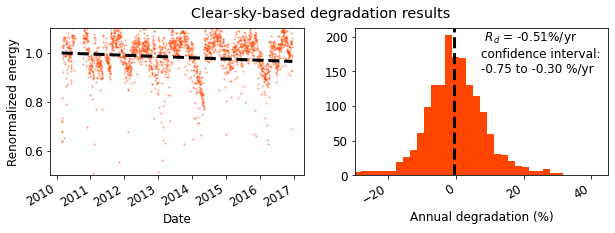

In [25]:
# Calculate the degradation rate using the YoY method
cs_yoy_rd, cs_yoy_ci, cs_yoy_info = rdtools.degradation_year_on_year(
    clearsky_daily,
    confidence_level=68.2
)

# Note the default confidence_level of 68.2 is appropriate if you would like to 
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results
clearsky_fig = rdtools.degradation_summary_plots(
    cs_yoy_rd, cs_yoy_ci, cs_yoy_info, clearsky_daily,
    summary_title='Clear-sky-based degradation results',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, plot_color='orangered',
    bins=100);

print('The P95 exceedance level with the clear sky analysis is %.2f%%/yr' %
      cs_yoy_info['exceedance_level'])

In [26]:
print(cs_yoy_rd)
print(cs_yoy_ci)

-0.5089691988110401
[-0.7498017 -0.3010554]


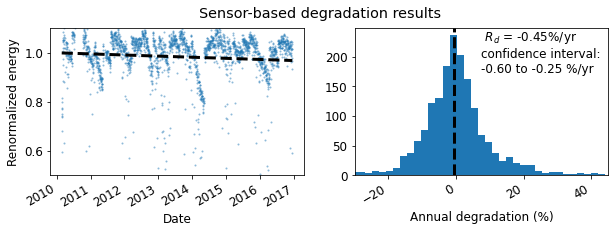

In [27]:
# Compare to previous sensor results
degradation_fig